In [ ]:
import os
# Version for filename
ver = 'GRU'  # GRU or LSTM

date = "mother_folder"
dl_folder = f"base_path/{date}_DL"

dl_number = "project_name"
#os.mkdir(f"{dl_folder}/model_{dl_number}")

In [ ]:
fs = 20  # sampling rate
look_frame = 30  

In [3]:
# Ignore warning
import os
import tensorflow as tf
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

import numpy
#import pandas
import matplotlib.pyplot as plt
from scipy import io
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D, Bidirectional
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

In [4]:
# Allow grouth option of GPU
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [5]:
# Clear session
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [ ]:
import tqdm
import numpy as np

acc_list = []
val_acc_list = []
loss_list = []
val_loss_list = []
for n in tqdm.tqdm(range(5)):
    model_dir = os.path.join(os.path.join(dl_folder, f"model_{dl_number}"), f"model_{n}")

    acc     = np.load(os.path.join(model_dir, f"train_accuracy.npy"))
    val_acc = np.load(os.path.join(model_dir, f"valid_accuracy.npy"))
    acc_list.append(acc)
    val_acc_list.append(val_acc)

    loss     = np.load(os.path.join(model_dir, f"train_loss.npy"))
    val_loss = np.load(os.path.join(model_dir, f"valid_loss.npy"))
    loss_list.append(loss)
    val_loss_list.append(val_loss)

acc_list = np.array(acc_list)
val_acc_list = np.array(val_acc_list)
loss_list = np.array(loss_list)
val_loss_list = np.array(val_loss_list)

print(loss_list.shape, val_loss_list.shape)

100%|██████████| 5/5 [00:00<00:00, 18.84it/s]

(5, 30) (5, 30)


In [ ]:
# best model for loss

flat_index = val_loss_list.argmin()  
row, col = np.unravel_index(flat_index, val_loss_list.shape)
print(row, col)  

3 28


In [8]:
mean_acc = np.mean(acc_list, axis=0)
sem_acc = np.std(acc_list, axis=0) / acc_list.shape[0]

mean_val_acc = np.mean(val_acc_list, axis=0)
sem_val_acc = np.std(val_acc_list, axis=0) / val_acc_list.shape[0]


mean_loss = np.mean(loss_list, axis=0)
sem_loss = np.std(loss_list, axis=0) / loss_list.shape[0]

mean_val_loss = np.mean(val_loss_list, axis=0)
sem_val_loss = np.std(val_loss_list, axis=0) / val_loss_list.shape[0]

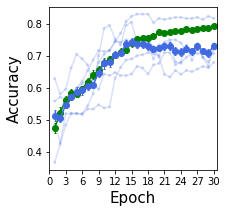

In [ ]:
plt.figure(figsize=(3, 3))

plt.errorbar(np.arange(1, mean_acc.shape[0]+1), 
    mean_acc,  
    yerr=sem_acc,   
    fmt='-o',       
    capsize=1,     
    elinewidth=1,  
    markeredgewidth=1,
    color='green'
)

plt.errorbar(np.arange(1, mean_val_acc.shape[0]+1), 
    mean_val_acc,   
    yerr=sem_val_acc, 
    fmt='-o',     
    capsize=1,      
    elinewidth=1,  
    markeredgewidth=1,
    color='royalblue'
)

for row in val_acc_list:
    plt.scatter(np.arange(1, mean_val_acc.shape[0]+1), row,
               color='royalblue',
                alpha=0.2,  
                s=10,      
                marker='o',
                edgecolors='none')

for row in val_acc_list:
    plt.plot(np.arange(1, mean_val_acc.shape[0]+1), row,
                color='royalblue',
                alpha=0.2,   

                )

plt.xlabel("Epoch", fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
ticks = np.arange(0, 31, 3)
labels = np.linspace(0, 30, len(ticks)).astype(int)
plt.xticks(ticks, labels)
plt.xlim(0, 30.5)

plt.show()

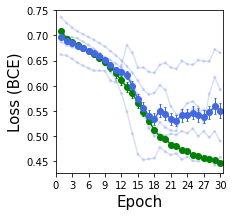

In [ ]:
plt.figure(figsize=(3, 3))

plt.errorbar(np.arange(1, mean_loss.shape[0]+1),
    mean_loss, 
    yerr=sem_loss, 
    fmt='-o',      
    capsize=1,    
    elinewidth=1,  
    markeredgewidth=1,
    color='green'
)

plt.errorbar(np.arange(1, mean_val_loss.shape[0]+1), 
    mean_val_loss,   
    yerr=sem_val_loss,     
    fmt='-o',       
    capsize=1,      
    elinewidth=1,   
    markeredgewidth=1,
    color='royalblue'
)

for row in val_loss_list:
    plt.scatter(np.arange(1, mean_val_loss.shape[0]+1), row,
                color='royalblue',
                alpha=0.2,   
                s=10,        
                marker='o',
                edgecolors='none')

for row in val_loss_list:
    plt.plot(np.arange(1, mean_val_loss.shape[0]+1), row,
                color='royalblue',
                alpha=0.2,  

                )

plt.xlabel("Epoch", fontsize=15)
plt.ylabel('Loss (BCE)', fontsize=15)
ticks = np.arange(0, 31, 3)
labels = np.linspace(0, 30, len(ticks)).astype(int)
plt.xticks(ticks, labels)
plt.xlim(0, 30.5)

plt.show()

In [ ]:
import shap
import numpy


def calc_shap(input_data, data_pred, model):
    data_idx = list(range(0, input_data.shape[0], 20))
    base = data_pred[data_idx].mean()
    explainer = shap.DeepExplainer(model, input_data[data_idx])
    shap_val = numpy.zeros(input_data.shape)
    
    # calculate shap value of all data
    BATCH_SIZE = 99 
    for idx in range(input_data.shape[0] // BATCH_SIZE + 1):
        if idx != input_data.shape[0] // BATCH_SIZE:
            bs = BATCH_SIZE
        else:
            bs = input_data.shape[0] % BATCH_SIZE
        input_shap = input_data[idx * BATCH_SIZE:(idx) * BATCH_SIZE + bs]
        shap_val[idx * BATCH_SIZE:(idx) * BATCH_SIZE + bs] = numpy.array(explainer.shap_values(input_shap))
    
    return shap_val, base

In [12]:
def calc_roc(y_pred, y_test):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    AUC = roc_auc_score(y_test, y_pred)
    opt_thr = thresholds[numpy.argmax(tpr - fpr)]

    return fpr, tpr, AUC, opt_thr

In [ ]:
# save accuracy, loss, and calculate tpr and fpr


ex_frames = 30  # frames per experiment

shap_vals = []
bases = []
best_acc, best_loss = [], []
for n in tqdm.tqdm(range(5)):
    model_dir = os.path.join(os.path.join(dl_folder, f"model_{dl_number}"), f"model_{n}")


    epoch = val_loss_list[n].argmin() + 1
    if epoch > 9:
        model_file_path = os.path.join(
            model_dir,
            f"{date}_{dl_number}_ver{ver}_epoch{epoch}.h5"
        )

    if epoch < 10:
        model_file_path = os.path.join(
            model_dir,
            f"{date}_{dl_number}_ver{ver}_epoch0{epoch}.h5"
        )        

    model = load_model(model_file_path)

    input_train = np.load(f"{model_dir}/{date}_{dl_number}_train_features.npy")
    trainY = np.load(f"{model_dir}/{date}_{dl_number}_train_targets.npy")
    input_valid = np.load(f"{model_dir}/{date}_{dl_number}_valid_features.npy")
    validY = np.load(f"{model_dir}/{date}_{dl_number}_valid_targets.npy")

    train_pred = model.predict(input_train)
    fpr_tr, tpr_tr, AUC_tr, opt_thr_tr = calc_roc(train_pred, trainY)
    np.save((f"{model_dir}/{date}_{dl_number}_train_fpr.npy"), fpr_tr)
    np.save((f"{model_dir}/{date}_{dl_number}_train_tpr.npy"), tpr_tr)
    np.save((f"{model_dir}/{date}_{dl_number}_train_auc.npy"), AUC_tr)
    np.save((f"{model_dir}/{date}_{dl_number}_train_threshold.npy"), opt_thr_tr)

    valid_pred = model.predict(input_valid)
    fpr_va, tpr_va, AUC_va, opt_thr_va = calc_roc(valid_pred, validY)
    np.save((f"{model_dir}/{date}_{dl_number}_valid_fpr.npy"), fpr_va)
    np.save((f"{model_dir}/{date}_{dl_number}_valid_tpr.npy"), tpr_va)
    np.save((f"{model_dir}/{date}_{dl_number}_valid_auc.npy"), AUC_va)
    np.save((f"{model_dir}/{date}_{dl_number}_valid_threshold.npy"), opt_thr_va)


    classified_valid_pred = []
    for f in range(valid_pred.shape[0]):
        if valid_pred[f, 0] > opt_thr_va:
            classified_valid_pred.append(1)
        else:
            classified_valid_pred.append(0)
    classified_valid_pred = np.array(classified_valid_pred)

    shap_val, base = calc_shap(input_valid, valid_pred, model)

    np.save((f"{model_dir}/{date}_{dl_number}_shap_val.npy"), np.array(shap_val))
    np.save((f"{model_dir}/{date}_{dl_number}_shap_base.npy"), base)

    shap_vals.append(np.array(shap_val))
    bases.append(base)

    
    first_positives = []
    for ex in range(int(input_valid.shape[0]/ex_frames)):
        for f in range(20, ex_frames):
            if classified_valid_pred[ex*ex_frames+f] == 1 and np.all(classified_valid_pred[ex*ex_frames+20:ex*ex_frames+f] == 0):
                first_positives.append(ex*ex_frames+f)
    first_positives = np.array(first_positives)
    np.save((f"{model_dir}/{date}_{dl_number}_valid_1st_positive_frames.npy"), first_positives)


    best_acc.append(val_acc_list[n][epoch-1])
    best_loss.append(val_loss_list[n][epoch-1])
                
best_acc, best_loss = np.array(best_acc), np.array(best_loss)

print(shap_vals[0].shape)
print(first_positives)
print(best_acc.shape, best_loss.shape)

100%|██████████| 5/5 [02:53<00:00, 34.78s/it]

(210, 31, 10)
[ 20  50 140 170 200 230 290]


In [15]:
np.save((f"{dl_folder}/model_{dl_number}/{date}_{dl_number}_valid_accuracy_best.npy"), best_acc)
np.save((f"{dl_folder}/model_{dl_number}/{date}_{dl_number}_valid_loss_best.npy"), best_loss)